# Generating pass features

In [1]:
import os
import timeit
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import collections

## Data Reading

In [ ]:
data_root = r"E:\NU\sideprojects\us soccer hackathon\Hackathon Raw Files\Full Datasets - Opta\MLS"
data_list = []
for filename in os.listdir(data_root): 
    MLS_Part = pd.read_csv(data_root + r'\\' + filename)
    MLS_Part['season'] = filename.split()[1]
    data_list.append(MLS_Part)

In [ ]:
data = pd.concat(data_list, axis=0)

In [ ]:
del data_list

In [ ]:
data.to_csv(r"E:\NU\sideprojects\us soccer hackathon\Hackathon Raw Files\MLS.csv")

In [12]:
fields = ['player_position', 'season', 'competition_id', 'game_id', 'team_id', 'player_id','cross',
          'through_ball','launch','assist','second_assist','pull_back','in_swinger','outcome','event_id',
          'x','pass_end_x','event_type','offensive','defensive']

data = pd.read_csv(r"E:\NU\sideprojects\us soccer hackathon\Hackathon Raw Files\MLS.csv", usecols = fields, encoding='latin-1')

## Feature Selection

In [4]:
#data = pd.read_csv(r"E:\NU\sideprojects\us soccer hackathon\Hackathon Raw Files\Full Datasets - Opta\MLS\MLS 2017-2018.CSV")

C:\Users\HAO\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (288,298) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
pd.Series(['cross','through_ball','launch','assist','second_assist','pull_back','in_swinger']).isin(data.columns)
offensive_list = ['cross','through_ball','launch','assist','second_assist','pull_back','in_swinger']
data["offensive_main"] = 0
for element in offensive_list:
    data['offensive_main'] = data.offensive_main + data[element].fillna(0)

In [31]:
data['offensive_main'] = data.offensive_main>0

In [32]:
data.offensive_main.describe()

count     3806045
unique          2
top         False
freq      3585262
Name: offensive_main, dtype: object

In [33]:
idcols = ['competition_id', 'game_id', 'team_id', 'player_id','season']
features = data[idcols].drop_duplicates().dropna()

In [34]:
feature_pass_success = data[data.event_type == 'Pass'].groupby(['competition_id', 'game_id', 'team_id', 'player_id','season'],as_index=False).\
    agg({'outcome':sum,'event_id':'count'}).rename(columns = {'outcome':'successful_pass','event_id':'Pass'})

In [35]:
data['new_offense'] = (data.event_type=='Pass')&((data.x<data.pass_end_x)|(data.offensive_main==1))

In [36]:
# cross, throughball, launch, assist, second_assist, pullback, inswinger
feature_pass_offense = data[data.new_offense==1].groupby(['competition_id', 'game_id', 'team_id', 'player_id','season'],as_index=False).\
    agg({'outcome':'count'}).rename(columns = {'outcome':'offensive_pass'})

In [37]:
feature_pass_duel = data.fillna(0).groupby(['competition_id', 'game_id', 'team_id', 'player_id','season'],as_index=False).\
    agg({'defensive':sum,'offensive':sum}).rename(columns = {'defensive':'defensive_duel','offensive':'offensive_duel'})

In [38]:
features_pass_game = features.merge(feature_pass_success, on = ['competition_id', 'game_id', 'team_id', 'player_id','season'], how="left").\
    merge(feature_pass_offense, on = ['competition_id', 'game_id', 'team_id', 'player_id','season'], how="left").fillna(0).\
    merge(feature_pass_duel, on = ['competition_id', 'game_id', 'team_id', 'player_id','season'], how="left")

In [39]:
features_pass = features_pass_game.groupby(['player_id','season'], as_index=False).mean().drop(['team_id','game_id','competition_id'],1)

In [40]:
features_pass.head()

player_id         season  successful_pass       Pass  offensive_pass  \
0     1212.0  2015-2016.csv         7.714286  10.500000        6.500000   
1     1212.0  2016-2017.csv         5.714286   7.857143        4.857143   
2     1241.0  2013-2014.csv        17.722222  23.944444       18.388889   
3     1587.0  2014-2015.csv        24.750000  30.750000       20.250000   
4     1619.0  2012-2013.csv        26.925926  39.333333       28.148148   

   defensive_duel  offensive_duel  
0        1.857143        2.928571  
1        1.428571        1.714286  
2        0.000000        0.000000  
3        4.250000        1.000000  
4        0.000000        0.037037

In [41]:
# clustering

In [57]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler

# To capture performance metrics for assessing optimal number of clusters
# silhouette = []
# inertia = []

def scaleData(featureSet):
    featureSet = featureSet.drop(['player_id','season'],1)
    num_cols = featureSet.shape[1]
    scaler = StandardScaler()
    scaler.fit(featureSet)
    featureSet = scaler.transform(featureSet)
    return featureSet

features_pass_sd = scaleData(features_pass)    
    
# To capture model objects for each k
GMM_models = []

# Upper bound for range of k to try 
kmax = 10
for k in range(2, kmax):  
    # Create model object
    model = GaussianMixture(n_components=k, covariance_type='full', random_state=1234)
    
    # Train model object
    model.fit(features_pass_sd)
    
    # Get inertia calculated for trained model 
#     inertia.append(model.inertia_)
    
    # Calculate silhouette score of trained model
#     silhouette_score(x_pca, model.labels_)
    
    # Capture trained model object 
    GMM_models.append(model)

In [58]:
def plot_cluster_facet(df, weight, cluster_colname, col_wrap=4, ):
        """plot guitar tab plot for a single cluster"""
        df.cluster = df[cluster_colname].map(str) + " (" + round((df[weight]*100),2).map(str) + "%)"
        df = df.loc[:, df.columns != weight]
        
        sns.set(style="whitegrid")

        # "Melt" the dataset to "long-form" or "tidy" representation
        melt_df = pd.melt(df, cluster_colname, var_name="measurement")

        # Show the conditional means
        g = sns.factorplot(x="value", y="measurement",
                           col= cluster_colname,
                           col_wrap=col_wrap, 
                           data=melt_df, kind="point",
                           dodge=False,
                           size=4, aspect=.7);  # hue="smoker",

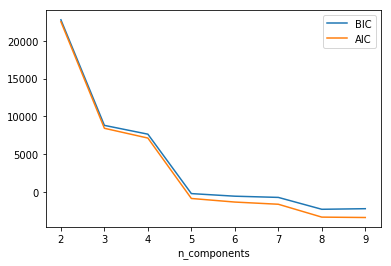

In [59]:
n_components = range(2, kmax)
plt.plot(n_components, [m.bic(features_pass_sd) for m in GMM_models], label='BIC')
plt.plot(n_components, [m.aic(features_pass_sd) for m in GMM_models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

In [71]:
bestGMM = GMM_models[2]
bestGMM_center = pd.concat([pd.DataFrame(bestGMM.means_),pd.DataFrame(bestGMM.weights_).rename(columns={0:'weight'})],axis=1)
bestGMM_center = bestGMM_center.reset_index().rename(columns={'index':'cluster'})

In [72]:
bestGMM_center

cluster         0         1         2         3         4    weight
0        0 -1.138216 -1.203947 -1.245341 -0.435823  0.457738  0.159169
1        1  0.652105  0.635753  0.669179  0.748813 -0.188570  0.357156
2        2 -0.214618 -0.162342 -0.018058 -1.026489 -0.912353  0.262932
3        3  0.021270  0.032856 -0.163239  0.325370  1.061772  0.220742

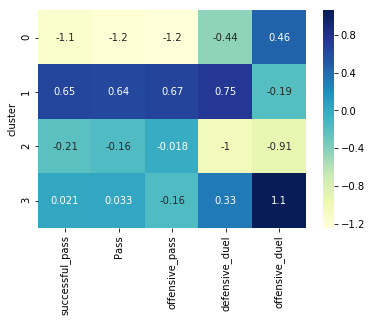

In [73]:
df_viz = bestGMM_center.set_index('cluster').drop('weight',1)
df_viz.columns = features_pass.columns[2:]
sns.heatmap(df_viz,annot=True,cmap="YlGnBu")
plt.show()

In [74]:
cluster_names = {0:'solo_forward',1:'coordinator',2:'dodger',3:'star'}

In [75]:
final_pass = features_pass[["player_id","season"]]
final_pass["cluster_pass"] = bestGMM.predict(features_pass_sd)
final_pass.to_csv(r"E:\NU\sideprojects\us soccer hackathon\cluster_pass.csv",index=False)

C:\Users\HAO\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
